<a href="https://colab.research.google.com/github/matthewpecsok/4482_fall_2024/blob/main/tutorials/ethical_ai_tutorial_4482.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
## Load packages

import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate

# Import Data

In [ ]:
# read_csv has some defaults, we can just take the defaults here, but be aware they exist.
insurance_raw = pd.read_csv("https://raw.githubusercontent.com/matthewpecsok/4482_fall_2024/main/data/insurance.csv")
insurance = insurance_raw.copy()

# raw is the original unedited version of our data which can be useful for inspecting changes we've made
# compared to the original unedited data

# EDA

In [ ]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
insurance.describe(include='all')

,age,sex,bmi,children,smoker,region,expenses
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


## Gender Analysis

In [ ]:
insurance_raw.sex.value_counts(normalize=False)

male      676
female    662
Name: sex, dtype: int64

In [ ]:
insurance_raw.sex.value_counts(normalize=True).round(2)

male      0.51
female    0.49
Name: sex, dtype: float64

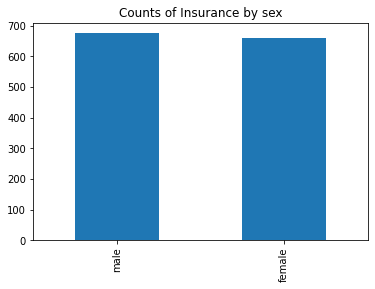

In [ ]:
insurance_raw.sex.value_counts(normalize=False).plot(kind='bar',title='Counts of Insurance by sex')
plt.show()

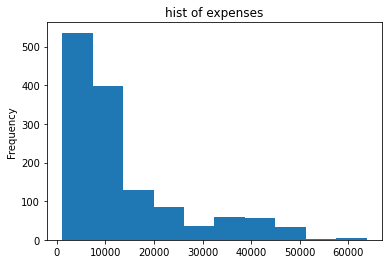

In [ ]:
insurance_raw.expenses.plot(kind='hist',title='hist of expenses')
plt.show()

let's create a binary target variable by calling expenses above 30,000 as HighExpenses. In this way we can turn this continuous feature into a categorical feature. for this tutorial it's easier to understand fairness for categorical features than continous (regression)

In [ ]:
insurance_raw['HighExpenses'] = insurance_raw['expenses'] > 30000
insurance['HighExpenses'] = insurance['expenses'] > 30000




In [ ]:
insurance_raw[['expenses','HighExpenses']].head(5)

,expenses,HighExpenses
0,16884.92400,False
1,1725.55230,False
2,4449.46200,False
3,21984.47061,False
4,3866.85520,False


In [ ]:
insurance_raw.drop('expenses',axis=1,inplace=True)
insurance.drop('expenses',axis=1,inplace=True)

In [ ]:
insurance.HighExpenses.value_counts()

False    1176
True      162
Name: HighExpenses, dtype: int64

In [ ]:
insurance.HighExpenses.value_counts(normalize=True).round(2)

False    0.88
True     0.12
Name: HighExpenses, dtype: float64

In [ ]:
pd.crosstab(insurance['sex'], insurance['HighExpenses'])

HighExpenses,False,True
sex,,
female,603,59
male,573,103


In [ ]:
ct = pd.crosstab(insurance_raw['sex'], insurance_raw['HighExpenses'])
ct.div(ct.sum(axis=1), axis=0).round(2)

HighExpenses,False,True
sex,,
female,0.91,0.09
male,0.85,0.15


## prepare for modeling

In [ ]:
y_target = insurance.pop('HighExpenses')
insurance_encoded_X = pd.get_dummies(insurance)
# now that we have encoded our data split it into train test

In [ ]:
insurance_encoded_X.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(insurance_encoded_X, y_target , test_size=0.3, random_state=0,stratify=y_target)

In [ ]:
tree_model_1 = tree.DecisionTreeClassifier(random_state=42,max_leaf_nodes=2)
tree_model_1

DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)

# Fit the model

In [ ]:
tree_model_1.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)

In [ ]:
tree_model_1.get_n_leaves() # how complex is our tree?

2

In [ ]:
pd.DataFrame(tree_model_1.feature_names_in_,tree_model_1.feature_importances_)

,0
0.0,age
0.0,bmi
0.0,children
0.0,sex_female
0.0,sex_male
0.0,smoker_no
1.0,smoker_yes
0.0,region_northeast
0.0,region_northwest
0.0,region_southeast


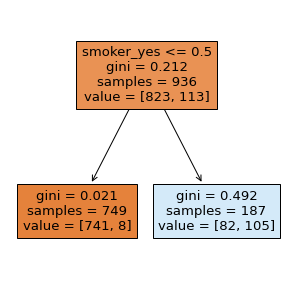

In [ ]:
fig = plt.figure(figsize=(5,5))
_ = tree.plot_tree(tree_model_1,
                   feature_names=insurance_encoded_X.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

In [ ]:
y_train_pred = tree_model_1.predict(X_train) # predict on train set
y_test_pred = tree_model_1.predict(X_test) # predict on test set

In [ ]:
y_train_pred[0:25]

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])

 ## train metrics and confusion matrix

In [ ]:
print(confusion_matrix(y_true=y_train,y_pred=y_train_pred))
print(metrics.classification_report(y_train,y_train_pred))

[[741  82]
 [  8 105]]
              precision    recall  f1-score   support

       False       0.99      0.90      0.94       823
        True       0.56      0.93      0.70       113

    accuracy                           0.90       936
   macro avg       0.78      0.91      0.82       936
weighted avg       0.94      0.90      0.91       936



## test metrics and confusion matrix

In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_test_pred))
print(metrics.classification_report(y_test,y_test_pred))

[[313  40]
 [  2  47]]
              precision    recall  f1-score   support

       False       0.99      0.89      0.94       353
        True       0.54      0.96      0.69        49

    accuracy                           0.90       402
   macro avg       0.77      0.92      0.81       402
weighted avg       0.94      0.90      0.91       402



now let's find out what kind of errors we are getting by gender. a simple strategy is to put the test predictions BACK into the test X dataframe so we can then filter by gender, in addition you must also put the real target value back into the dataframe as it was popped.

Remember here our goal is to generate the same metrics we have generated in the past (ie accuracy precision recall) but for only males, and only females to see if some of thos metrics are worse by gender. for example is precision much better for men than women?

Remember our X data is encoded so our filter must take that into account.

# Prepare the data for model evaluation by gender

## put the predictions and the real values into X_test

For example:

```
X_test['y_true'] = y_test
X_test['y_pred'] = y_pred

```

In [ ]:
# TODO by Student
# put the true and predicted values BACK into the X_test dataframe

X_test['y_true'] = y_test
X_test['y_pred'] = y_test_pred

In [ ]:
X_test.head(5)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,y_true,y_pred
930,26,46.53,1,0,1,1,0,0,0,1,0,False,False
811,33,42.94,3,1,0,1,0,0,1,0,0,False,False
404,31,20.40,0,0,1,1,0,0,0,0,1,False,False
898,18,40.26,0,1,0,1,0,0,0,1,0,False,False
188,41,32.20,1,1,0,1,0,0,0,0,1,False,False


In [ ]:
X_test.shape

(402, 13)

## Subset our dataframe into 2 dataframes, split by gender

create 2 new dataframes, one for female, one for male by filtering the dataframes for gender.


In [ ]:
X_test['sex_male']==1

930      True
811     False
404      True
898     False
188     False
        ...  
829      True
1189    False
828      True
1012    False
831     False
Name: sex_male, Length: 402, dtype: bool

In [ ]:
X_test['sex_male']==0

930     False
811      True
404     False
898      True
188      True
        ...  
829     False
1189     True
828     False
1012     True
831      True
Name: sex_male, Length: 402, dtype: bool

In [ ]:
new_df1_male = X_test[X_test['sex_male']==1].copy()
new_df2_female = X_test[X_test['sex_male']==0].copy()
# TODO by Student

now we have our filtered dataframes by gender, generate the performance metrics again for each gender's prediction in test.

this is fairly straightforward now. you should have two dataframes, each with a specific gender and only that gender in the dataframe. you should also have two columns in those dataframes with the predicted value and the true value for the target variable. Simply pass those columns into the metrics and confusion matrix.



```
print(confusion_matrix(y_true=df.y_true,y_pred=df.y_pred))
print(metrics.classification_report(df.y_true,df.y_pred))
```



female results:


In [ ]:
# generate confusion matrix and classification reports for females
# TODO by Student

print(confusion_matrix(y_true=new_df2_female.y_true,y_pred=new_df2_female.y_pred))
print(metrics.classification_report(new_df2_female.y_true,new_df2_female.y_pred))

[[154  21]
 [  1  19]]
              precision    recall  f1-score   support

       False       0.99      0.88      0.93       175
        True       0.47      0.95      0.63        20

    accuracy                           0.89       195
   macro avg       0.73      0.92      0.78       195
weighted avg       0.94      0.89      0.90       195



male results:


In [ ]:
# generate confusion matrix and classification reports for males
# TODO by Student

print(confusion_matrix(y_true=new_df1_male.y_true,y_pred=new_df1_male.y_pred))
print(metrics.classification_report(new_df1_male.y_true,new_df1_male.y_pred))

[[159  19]
 [  1  28]]
              precision    recall  f1-score   support

       False       0.99      0.89      0.94       178
        True       0.60      0.97      0.74        29

    accuracy                           0.90       207
   macro avg       0.79      0.93      0.84       207
weighted avg       0.94      0.90      0.91       207



whats the difference in counts between the two matrices?

In [ ]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference

In [ ]:
print(demographic_parity_difference(y_test,
                                    y_test_pred,
                                    sensitive_features=X_test['sex_male']))

0.021924934968413246


In [ ]:
print(equalized_odds_difference(y_test,
                                    y_test_pred,
                                    sensitive_features=X_test['sex_male']))

0.015517241379310431


In [ ]:
print(demographic_parity_difference(y_test,
                                    y_test_pred,
                                    sensitive_features=X_test['region_southeast']))


0.18403078403078404


In [ ]:
print(equalized_odds_difference(y_test,
                                    y_test_pred,
                                    sensitive_features=X_test['region_southeast']))



0.07725127087872186
